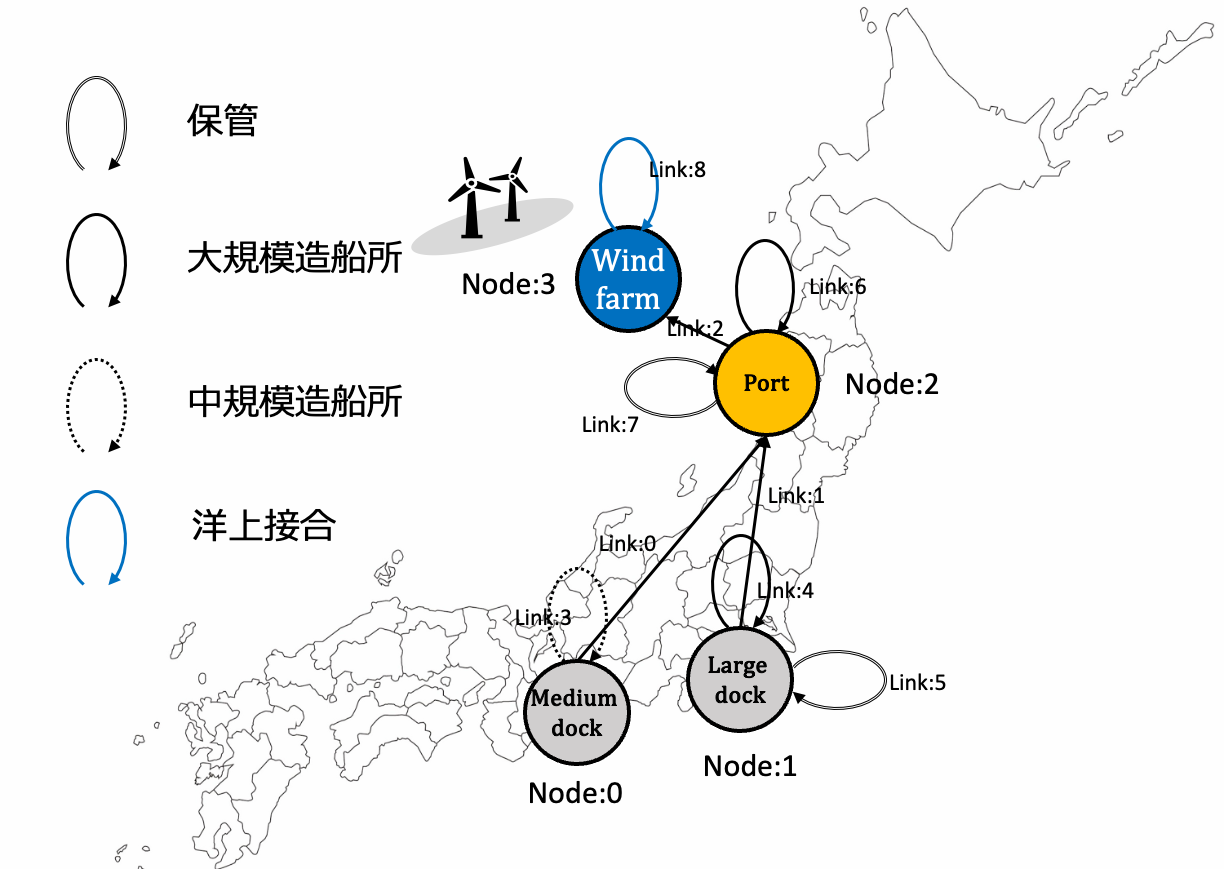

まとめて表示

In [1]:
## ノードとリンクの設定
# ノード
n_taple = ("00", "01", "02", "03")

# リンク
l_taple = ("0002", "0102", "0203",
        #中規模組立,大規模組立,  保管,大規模組立,  保管, 洋上接合
           "0000", "0101", "0101", "0202", "0202", "0303")

# 中規模組立 = モジュール → ハーフボディ1とハーフボディ3へ
# 大規模組立 = モジュール → 浮体基礎へ
# 保管 = グラフループを経由することで1ヶ月間保管したことを表現
# 洋上接合 = ハーフボディ1とハーフボディ3 → 浮体基礎へ

# m = 期間
# i = リンク
# j = 製品
# k = 流出・流入



# ライブラリのインポート
import numpy as np
from pyscipopt import Model, quicksum



# モデルを作成
model = Model("20240927")

# 12ヶ月間の計画
# ここは入力
N_network = 12

# ノード数、リンク数、製品数
num_node = len(n_taple)     # number of nodes = 4
num_link = len(l_taple)     # number of links = 9
num_product = 4             # number of components and products

foundation = 20

## 変数の設定
# 輸送量の変数
x = {}
for m in range(0, N_network):
    for i in range(0, num_link):
        for j in range(0, num_product):
            for k in range(0, 2):
                x[m,i,j,k] = model.addVar(vtype="I", name="x[%s,%s,%s,%s]" % (m, i, j, k))

# 需給量を表す変数
ds = {}
for m in range(0, N_network):
    for l in range(0, num_node):
        for j in range(0, num_product):
            ds[m,l,j] = model.addVar(vtype="I",ub = 15, lb = -15, name="ds[%s,%s,%s]" % (m, l, j))



## A行列の設定
# 流出
A_plus = [m for m in range(N_network)] 

# A_plus番号を入れる関数（enumerate を使用）
def An_idx(org_n_idx: str, dst_n_index: str):
    l_idx = org_n_idx + dst_n_index
    
    # l_taple の全てのインデックスを列挙し、該当するインデックスを探す
    indices = [i for i, val in enumerate(l_taple) if val == l_idx]
    # 最初に見つかったインデックスだけではなく、すべてのインデックスを返す
    return n_taple.index(org_n_idx), indices

A_plus[0] = np.zeros((len(n_taple), len(l_taple)))

A_plus[0][An_idx("00", "02")] = 1
A_plus[0][An_idx("01", "02")] = 1
A_plus[0][An_idx("02", "03")] = 1
A_plus[0][An_idx("00", "00")] = 1
A_plus[0][An_idx("01", "01")] = 1
A_plus[0][An_idx("02", "02")] = 1
A_plus[0][An_idx("03", "03")] = 1

# 期間2以降
for m in range(1, N_network):
    A_plus[m] = A_plus[0].copy()


# 流入
A_minus = [m for m in range(N_network)]

# A_minus番号を入れる関数
def An_minus_idx(org_n_idx: str, dst_n_index: str):
    l_idx = org_n_idx + dst_n_index

    # l_taple の全てのインデックスを列挙し、該当するインデックスを探す
    indices = [i for i, val in enumerate(l_taple) if val == l_idx]
    # 最初に見つかったインデックスだけではなく、すべてのインデックスを返す
    return n_taple.index(dst_n_index), indices

# 流入
A_minus[0] = np.zeros((len(n_taple), len(l_taple)))

A_minus[0][An_minus_idx("00", "02")] = 1
A_minus[0][An_minus_idx("01", "02")] = 1
A_minus[0][An_minus_idx("02", "03")] = 1
A_minus[0][An_minus_idx("00", "00")] = 1
A_minus[0][An_minus_idx("01", "01")] = 1
A_minus[0][An_minus_idx("02", "02")] = 1
A_minus[0][An_minus_idx("03", "03")] = 1

# 期間2以降
for m in range(1, N_network):
    A_minus[m] = A_minus[0].copy()



## 風車の需給量の設定
b = [m for m in range(N_network)]

for m in range(0, N_network):
    b[m] = np.array([
        # node
        #    module, halfbody1, halfbody3, foundation
        [ ds[m,0,0], ds[m,0,1], ds[m,0,2], ds[m,0,3]], # Node0、津（中規模造船所・専業、中規模組立）
        [ ds[m,1,0], ds[m,1,1], ds[m,1,2], ds[m,1,3]], # Node1、磯子（大規模造船所・兼業、大規模組立 & 保管）
        [ ds[m,2,0], ds[m,2,1], ds[m,2,2], ds[m,2,3]], # Node2、秋田港（大規模造船所、大規模組立 & 保管）
        [ ds[m,3,0], ds[m,3,1], ds[m,3,2], ds[m,3,3]], # Node3、能代沖（設置海域、洋上接合）
    ])

## 制約条件は重ねると矛盾してout
# 12期間で20基の浮体基礎を設置
# Node0,1,2からのみ供給
model.addCons(quicksum(ds[m, 0, 0] + ds[m, 1, 0] + ds[m, 2, 0] for m in range(N_network)) == foundation)
# 需要量、設置時期、期間7から12
model.addCons(quicksum(ds[m, 3, 3] for m in range(6, N_network)) == - foundation)

# 専業・兼業、規模などを設定
# 津は中規模専業造船所、12期間に9期分のモジュールを組立可能
model.addCons(quicksum(ds[m, 0, 0] for m in range(N_network)) <= 9)
# 磯子は大規模兼業造船所、期間1〜3に計3期分のモジュールを組立可能
model.addCons(quicksum(ds[m, 1, 0] for m in range(0, 3)) <= 3)
# それ以外の期間は0
model.addCons(quicksum(ds[m, 1, 0] for m in range(3, N_network)) == 0)
# 秋田港は12期間で12期分のモジュールを組立可能
model.addCons(quicksum(ds[m, 2, 0] for m in range(N_network)) <= 12)

## フローにかかるコスト
c_x = [m for m in range(N_network)]
# 1年目
c_x[0] = np.array([
    # link
    #     module,  halfbody1,  halfbody3,  foundation
    # outflow, inflow
    [[   1,   1],[   1,   1],[   1,   1],[   1,   1]], # link0、0→2、津→秋田港
    [[   1,   1],[   1,   1],[   1,   1],[   1,   1]], # link1、1→2、磯子→秋田港
    [[   1,   1],[   1,   1],[   1,   1],[   1,   1]], # link2、2→3、秋田港→能代沖
    [[   1,   1],[   1,   1],[   1,   1],[   1,   1]], # link3、0→0、津（中規模組立）
    [[   1,   1],[   1,   1],[   1,   1],[   1,   1]], # link4、1→1、磯子（大規模組立）
    [[   1,   1],[   1,   1],[   1,   1],[   1,   1]], # link5、1→1、磯子（保管）
    [[   1,   1],[   1,   1],[   1,   1],[   1,   1]], # link6、2→2、秋田港（大規模組立）
    [[   1,   1],[   1,   1],[   1,   1],[   1,   1]], # link7、2→2、秋田港（保管）
    [[   1,   1],[   1,   1],[   1,   1],[   1,   1]]  # link8、3→3、能代沖（洋上接合）
])
# 期間2以降
for m in range(1, N_network):
    c_x[m] = c_x[0].copy()



## キャパシティ
u = [m for m in range(N_network)]
# 期間1
u[0] = np.array([
    # link
    #     module,  halfbody1,  halfbody3,  foundation
    # outflow, inflow
    [[   0,   0],[   1,   1],[   1,   1],[   0,   0]], # link0、0→2、津→秋田港
    [[   1,   1],[   0,   0],[   0,   0],[   1,   1]], # link1、1→2、磯子→秋田港
    [[   0,   0],[   0,   0],[   0,   0],[   0,   0]], # link2、2→3、秋田港→能代沖
    [[   1,   0],[   0,   1],[   0,   1],[   0,   0]], # link3、0→0、津（中規模組立）
    [[   1,   0],[   0,   0],[   0,   0],[   0,   1]], # link4、1→1、磯子（大規模組立）
    [[  20,  20],[  20,  20],[  20,  20],[  20,  20]], # link5、1→1、磯子（保管）
    [[   1,   0],[   0,   0],[   0,   0],[   0,   1]], # link6、2→2、秋田港（大規模組立）
    [[  20,  20],[  20,  20],[  20,  20],[  20,  20]], # link7、2→2、秋田港（保管）
    [[   0,   0],[   0,   0],[   0,   0],[   0,   0]]  # link8、3→3、能代沖（洋上接合）
])

# 設置不可能時のキャパシティ
for m in range(1, 6):
    u[m] = u[0].copy()
# 設置可能時期のキャパシティ
for m in range(6, N_network):
    u[m] = np.array([
        # 設置可能時期
        [[   0,   0],[   1,   1],[   1,   1],[   0,   0]], # link0、0→2、津→秋田港
        [[   1,   1],[   0,   0],[   0,   0],[   1,   1]], # link1、1→2、磯子→秋田港
        [[   0,   0],[   2,   2],[   2,   2],[   2,   2]], # link2、2→3、秋田港→能代沖
        [[   1,   0],[   0,   1],[   0,   1],[   0,   0]], # link3、0→0、津（中規模組立）
        [[   1,   0],[   0,   0],[   0,   0],[   0,   1]], # link4、1→1、磯子（大規模組立）
        [[  20,  20],[   0,   0],[   0,   0],[  20,  20]], # link5、1→1、磯子（保管）
        [[   1,   0],[   0,   0],[   0,   0],[   0,   1]], # link6、2→2、秋田港（大規模組立）
        [[  20,  20],[  20,  20],[  20,  20],[  20,  20]], # link7、2→2、秋田港（保管）
        [[   0,   0],[   2,   0],[   2,   0],[   0,   2]]  # link8、3→3、能代沖（洋上接合）
    ])



## 目的関数
# フローにかかるコスト（輸送コスト）
# 期間ごとに分ける
Flow_cost_list = [m for m in range(N_network)]

# 各期間の輸送、作業にかかるコスト
for m in range(N_network):
    Flow_cost_list[m] = quicksum(c_x[m][i,j,k] * x[m,i,j,k] for i in range(num_link) for j in range(num_product) for k in range(2))

Flow_cost = 0

for m in range(N_network):
    Flow_cost += Flow_cost_list[m]

# 目的関数の式
model.setObjective(Flow_cost, sense = "minimize")



## 制約条件
# ノードからの流出とノードへの流入の制約
for m in range(0, N_network):
    for l in range(0, num_node):
        for j in range(0, num_product):
            model.addCons(quicksum((A_plus[m][l,i] * x[m,i,j,0] - A_minus[m][l,i] * x[m,i,j,1]) for i in range(num_link)) <= b[m][l,j])

# 輸送するときにplusとminusで同じ値になる
for m in range(0, N_network):
    for aa in range(0, 3): # 輸送
        for j in range(0, num_product):
            model.addCons(x[m,aa,j,0] == x[m,aa,j,1])

# フローがキャパシティを超えないように
for m in range(0, N_network):
    for i in range(0, num_link):
        for j in range(0, num_product):
            for k in range(0, 2):
                model.addCons(x[m,i,j,k] <= u[m][i,j,k])


# 組立・保管のB行列・部材比率の制約条件
# Node0,津（中規模造船所・専業、中規模組立）
for m in range(N_network):
    model.addCons(x[m,3,0,0] == x[m,3,1,1])
    model.addCons(x[m,3,0,0] == x[m,3,2,1])
    model.addCons(x[m,3,0,0] * 0 == x[m,3,0,1])

# Node1,磯子（大規模造船所・兼業、大規模組立 & 保管）
# 組立
for m in range(N_network):
    model.addCons(x[m,4,0,0] == x[m,4,3,1])
    model.addCons(x[m,4,0,0] * 0 == x[m,4,0,1])
# 保管
    model.addCons(x[m,5,0,0] == x[m,5,0,1])
    model.addCons(x[m,5,3,0] == x[m,5,3,1])

# Node2,秋田港（大規模造船所、大規模組立 & 保管）
# 組立
for m in range(N_network):
    model.addCons(x[m,6,0,0] == x[m,6,3,1])
    model.addCons(x[m,6,0,0] * 0 == x[m,6,0,1])
# 保管
    for j in range(0, num_product):
        model.addCons(x[m,7,j,0] == x[m,7,j,1])

# Node3,能代沖（設置海域、洋上接合）
# はじめに部材比率の設定
for m in range(N_network):
    model.addCons(x[m,8,1,0] == x[m,8,2,0])
# 洋上接合
    model.addCons(x[m,8,1,0] / 2 + x[m,8,2,0] / 2 == x[m,8,3,1])
    model.addCons(x[m,8,1,0] * 0 == x[m,8,1,1])
    model.addCons(x[m,8,2,0] * 0 == x[m,8,2,1])


# 異なる期間で部材の数が一致するように 制約e
# 保管メイン、組立も
## m年目に輸送された or m-1年目に保管した部材をm年目に使用 or 再保管 ##
## m年目に供給がある場合、左辺に追加

# Node1,磯子（大規模造船所・兼業、大規模組立 & 保管）
# 期間1
# モジュールのみ（モジュールには需給の流入が必要）
model.addCons(ds[0,1,0] + x[0,4,0,1] == x[0,1,0,0] + x[0,4,0,0] + x[0,5,0,0])
# 浮体基礎のみ
model.addCons(x[0,4,3,1] == x[0,1,3,0] + x[0,5,3,0])
# 期間2以降
for m in range(1, N_network):
    # モジュールのみ（モジュールには需給の流入が必要）
    model.addCons(ds[m,1,0] + x[m,4,0,1] + x[m-1,5,0,1] == x[m,1,0,0] + x[m,4,0,0] + x[m,5,0,0])
    # 浮体基礎のみ
    model.addCons(x[m,4,3,1] + x[m-1,5,3,1] == x[m,1,3,0] + x[m,5,3,0])

# Node2,秋田港（大規模造船所、大規模組立 & 保管）
# モジュールのみ（モジュールには需給の流入が必要）
model.addCons(ds[0,2,0] + x[0,0,0,1] + x[0,1,0,1] + x[0,6,0,1] == x[0,6,0,0] + x[0,7,0,0])
# halfbody、浮体基礎
for j in range(1, num_product):
    model.addCons(x[0,0,j,1] + x[0,1,j,1] + x[0,6,j,1] == x[0,6,j,0] + x[0,7,j,0] + x[0,2,j,0])
# 期間2以降
for m in range(1, N_network):
    # モジュールのみ（モジュールには需給の流入が必要）
    model.addCons(ds[m,2,0] + x[m,0,0,1] + x[m,1,0,1] + x[m,6,0,1] + x[m-1,7,0,1] == x[m,6,0,0] + x[m,7,0,0])
    # halfbody、浮体基礎
    for j in range(1, num_product):
        model.addCons(x[m,0,j,1] + x[m,1,j,1] + x[m,6,j,1] + x[m-1,7,j,1] == x[m,6,j,0] + x[m,7,j,0] + x[m,2,j,0])


# 輸送面に関しても部材が一致するように、制約としては上と同じ
# Node0,津（中規模造船所・専業、中規模組立）
for m in range(N_network):
    for j in range(num_product):
        model.addCons(x[m,3,j,1] == x[m,0,j,0])
# Node3,能代沖（設置海域、洋上接合）
    for j in range(num_product-1): # 浮体基礎は含めてはいけない（需要なので）
        model.addCons(x[m,8,j,0] == x[m,2,j,1])



# 最適化
model.setParam("limits/time", 300.0)
# 出力を非表示
model.hideOutput()
model.optimize()

# 結果表示
if model.getStatus() == "optimal":
    print("Optimal value:", model.getObjVal())
    print("Solution:")
    # output
    for (m,i,j,k) in x:
        if model.getVal(x[m,i,j,k]) >= 0.5:
            print(f"x[{m},{i},{j},{k}] = {model.getVal(x[m,i,j,k])}")
        
    for (m,l,j) in ds:
        val = model.getVal(ds[m,l,j])
        if val <= 10 and val != 0:
            print(f"ds[{m},{l},{j}] = {model.getVal(ds[m,l,j])}")

Optimal value: 246.0
Solution:
x[1,6,0,0] = 1.0
x[1,6,3,1] = 1.0
x[1,7,3,0] = 1.0
x[1,7,3,1] = 1.0
x[2,4,0,0] = 1.0
x[2,4,3,1] = 1.0
x[2,5,3,0] = 1.0
x[2,5,3,1] = 1.0
x[2,6,0,0] = 1.0
x[2,6,3,1] = 1.0
x[2,7,3,0] = 2.0
x[2,7,3,1] = 2.0
x[3,5,3,0] = 1.0
x[3,5,3,1] = 1.0
x[3,6,0,0] = 1.0
x[3,6,3,1] = 1.0
x[3,7,3,0] = 3.0
x[3,7,3,1] = 3.0
x[4,0,1,0] = 1.0
x[4,0,1,1] = 1.0
x[4,0,2,0] = 1.0
x[4,0,2,1] = 1.0
x[4,3,0,0] = 1.0
x[4,3,1,1] = 1.0
x[4,3,2,1] = 1.0
x[4,5,3,0] = 1.0
x[4,5,3,1] = 1.0
x[4,6,0,0] = 1.0
x[4,6,3,1] = 1.0
x[4,7,1,0] = 1.0
x[4,7,1,1] = 1.0
x[4,7,2,0] = 1.0
x[4,7,2,1] = 1.0
x[4,7,3,0] = 4.0
x[4,7,3,1] = 4.0
x[5,0,1,0] = 1.0
x[5,0,1,1] = 1.0
x[5,0,2,0] = 1.0
x[5,0,2,1] = 1.0
x[5,3,0,0] = 1.0
x[5,3,1,1] = 1.0
x[5,3,2,1] = 1.0
x[5,5,3,0] = 1.0
x[5,5,3,1] = 1.0
x[5,6,0,0] = 1.0
x[5,6,3,1] = 1.0
x[5,7,1,0] = 2.0
x[5,7,1,1] = 2.0
x[5,7,2,0] = 2.0
x[5,7,2,1] = 2.0
x[5,7,3,0] = 5.0
x[5,7,3,1] = 5.0
x[6,0,1,0] = 1.0
x[6,0,1,1] = 1.0
x[6,0,2,0] = 1.0
x[6,0,2,1] = 1.0
x[6,2,1,0] = 2.0


保管について  
m年目の輸送流入 + m-1年目の保管流入 = m年目の輸送流出 + m年目の保管流出

モジュールの保管について（供給がある場合）
需要量変数 + m年目の輸送流入 + m-1年目の保管流入 = m年目の輸送流出 + m年目の保管流出

### 表

In [2]:
import pandas as pd
# 行、列を全て表示
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# 小数点1桁
pd.options.display.float_format = "{:.1f}".format

indexの作成

In [3]:
I_list = ["No0 0→2 津→秋田港",
          "No1 1→2 磯子→秋田港",
          "No2 2→3 秋田港→能代沖",
          "No3 0→0 津(中規模組立)",
          "No4 1→1 磯子(大規模組立)",
          "No5 1→1 磯子(保管)",
          "No6 2→2 秋田港(大規模組立)",
          "No7 2→2 秋田港(保管)",
          "No8 3→3 能代沖(洋上接合)"]

In [4]:
I = [aaa for aaa in range(num_link * N_network)]

for m in range(N_network):
    for i in range(num_link):
        I[i + m * num_link] = (f'期間{m+1},{I_list[i]}')

値とインデックスの対応

In [5]:
ppi = pd.DataFrame({'module'    :(model.getVal(x[m,i,0,1]) for m in range(N_network) for i in range(num_link)),
                    'halfbody1' :(model.getVal(x[m,i,1,1]) for m in range(N_network) for i in range(num_link)),
                    'halfbody3' :(model.getVal(x[m,i,2,1]) for m in range(N_network) for i in range(num_link)),
                    'foundation':(model.getVal(x[m,i,3,1]) for m in range(N_network) for i in range(num_link))},
                    index = I)

表示

In [6]:
# 値を整数として表示
ppi = ppi.loc[(ppi["module"] >= 1) | (ppi["halfbody1"] >= 1) | (ppi["halfbody3"] >= 1) | (ppi["foundation"] >= 1)]
ppi

,module,halfbody1,halfbody3,foundation
"期間2,No6 2→2 秋田港(大規模組立)",-0.0,-0.0,-0.0,1.0
"期間2,No7 2→2 秋田港(保管)",0.0,0.0,0.0,1.0
"期間3,No4 1→1 磯子(大規模組立)",-0.0,-0.0,-0.0,1.0
"期間3,No5 1→1 磯子(保管)",0.0,-0.0,-0.0,1.0
"期間3,No6 2→2 秋田港(大規模組立)",-0.0,-0.0,-0.0,1.0
"期間3,No7 2→2 秋田港(保管)",0.0,0.0,0.0,2.0
"期間4,No5 1→1 磯子(保管)",0.0,-0.0,-0.0,1.0
"期間4,No6 2→2 秋田港(大規模組立)",-0.0,-0.0,-0.0,1.0
"期間4,No7 2→2 秋田港(保管)",0.0,0.0,0.0,3.0
"期間5,No0 0→2 津→秋田港",-0.0,1.0,1.0,-0.0
